# 인물 포커싱 이미지 만들기

# 목차
### 기본 Segmentation 진행
1. 이미지 불러오기
2. Segmentation 적용
  - DeepLab 레이블 종류
  - Model 및 Weight 불러오기
  - Segmentation 수행
  - Segmentation 결과 시각화
3. 인물 Focusing
  - 인물 Mask 만들기
  - 원본 사진에 인물 mask 적용
  - 배경 Blur 처리
  - 원본 사진으로 Resize
  - Focus Image 생성
4. Focusing 메소드 만들기

<hr> 

### 문제 식별 및 해결방법
- 문제1. 불필요한 인원 포함
  - **Instance Segmenation model를 이용해 해결(Mask-RCNN)** 
  
  <br> 
  
- 문제2. 배경과 인물 경계선의 부자연스러움
  - **mask에 Blur를 처리해서 경계면을 자연스럽게 적용**
  -**Blur된 mask를 원본 이미지에 적용할 때 Weight값처럼 적용**
    
<hr>

### Segmentation 활용

- **Focusing 테크닉을 이용해 이미지 합성(졸업사진)**

In [1]:
import os
import urllib
import tarfile

import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from model import DeepLabModel

# 이미지 불러오기
Focusing이 잘 나타나도록 인물이 비교적 큰 이미지 사용

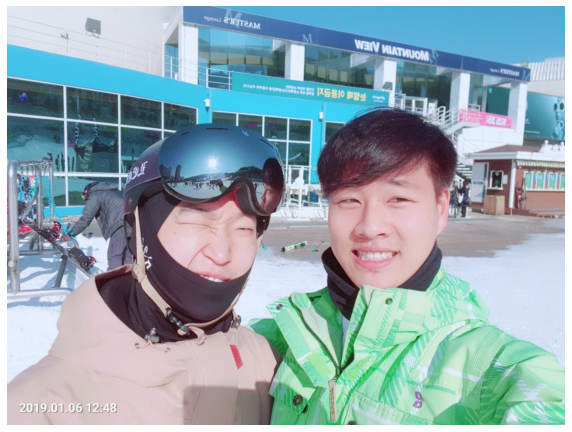

In [2]:
image_dir = os.getenv("HOME") + '/aiffel/human_segmentation/images/'
file_name = 'sakong2.jpg'

image = Image.open(os.path.join(image_dir, file_name))
image = np.array(image)

plt.figure(figsize=(10,10))
plt.imshow(image); plt.axis('off'); plt.show()

# Segmantation 적용
**사전학습이 된 DeepLab 모델 사용**

- DeepLab모델의 레이블 종류 정의
- Model 구조 및 사전학습된 Weight 불러오기
- Segmentation 적용 후 class별로 분리(person)

### DeepLab 모델의 레이블 종류

In [3]:
LABEL_NAMES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
                'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
                'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv']
len(LABEL_NAMES)

21

### Model 및 Weights 불러오기
```request``` 메소드를 이용해 직접 인터넷에서 다운받은 후 불러오기

In [4]:
WEIGHT_URL = 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz'         # 사전학습된 weight의 파일명
DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'           # weight가 저장되어 있는 사이트
download_url = os.path.join(DOWNLOAD_URL_PREFIX, WEIGHT_URL)             # 사이트와 파일명을 합친 URL(== 다운로드 URL)

weight_dir = os.getenv('HOME') + '/aiffel/human_segmentation/models'     # weight가 다운로드된 폴더명
weight_name = 'deeplab_model.tar.gz'                                     # wieght가 다운로드됐을 때 파일명
weight_path = os.path.join(weight_dir, weight_name)                      # weight 파일의 path

tf.io.gfile.makedirs(weight_dir)                                         # weight가 저장되어 있는 폴더 생성
if not os.path.exists(weight_path):                                     # 이미 존재하면 pass
    print('Downloading Weight of DeepLabModel....')
    urllib.request.urlretrieve(download_url, weight_path)                # 다운로드 URL로부터 다운받은 후 weight 폴더에 저장

# 모델 생성
model = DeepLabModel(weight_path)                                        
print('Loaded DeepLabModel completely')

Loaded DeepLabModel completely


### Segmantation
```run``` 메소드를 이용해 Segmetation 적용
> **모델적용 결과 Resized된 이미지와 class로 구분되어 있는 Segmentation Featuremap이 생성**

In [5]:
# Resized된 이미지 & Segmentation Feature Map
resized_image, seg_map = model.run(image)
image_show = resized_image.copy()

# 이미지에 존재하는 Class 추출
detected_classes = np.unique(seg_map) 
print('Shape of Resized_image : ', resized_image.shape)
print('Shape of seg_map : ', seg_map.shape)

# 탐지된 Class 출력
print('\n' + "*"*60 + '\n')
print(f'{len(detected_classes)} class detected!')
for cls in detected_classes:
    print(f'{LABEL_NAMES[cls]}({cls})')

Shape of Resized_image :  (384, 513, 3)
Shape of seg_map :  (384, 513)

************************************************************

2 class detected!
background(0)
person(15)


### Segmantation 결과 시각화
**Segmentation Feature Map에 있는 모든 Class 표시**
- 배경도 class 중 하나로 취급하고 255값으로 대체(시각화용)
- 흰색 부분이 class

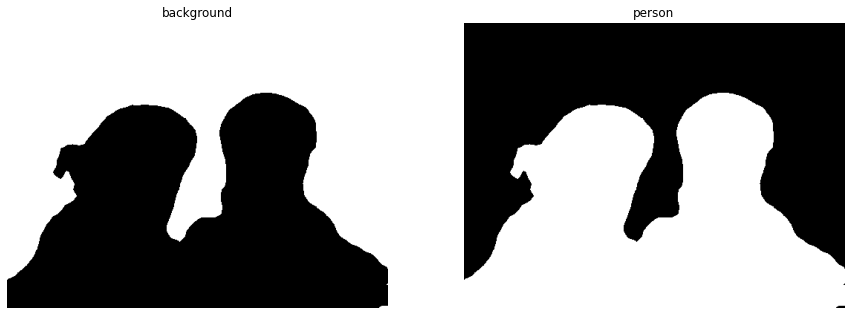

In [6]:
plt.figure(figsize=(15,15))
for i, cls in enumerate(detected_classes):          
    image_seg = np.where(seg_map == cls, 255, 0)      # 해당 class일 때 255, 나머지는 0
    plt.subplot(1,2,i+1)
    plt.imshow(image_seg, cmap='gray')
    plt.axis('off')
    plt.title(LABEL_NAMES[cls])

# 인물 Focusing
**인물 mask와 Blur처리 된 배경화면을 이용해 Focusing 적용**

### 인물 mask 만들기
**위에서 정의한 DeepLab의 레이블 종류를 이용해 Person인 경우에만 추출**

Shape of Mask :  (384, 513)


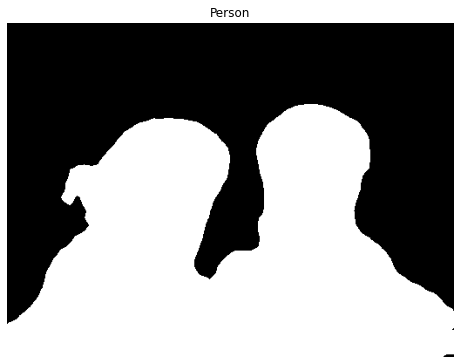

In [7]:
class_to_idx = {class_ : idx for idx, class_ in enumerate(LABEL_NAMES)} # 각 Class별 idx를 딕셔너리로 생성
person_mask = np.where(seg_map == class_to_idx['person'], 255, 0)        # Class 중 Person에 해당하는 부분만 추출
print('Shape of Mask : ', person_mask.shape)

plt.figure(figsize=(8,8))
plt.imshow(person_mask, cmap='gray'); plt.axis('off'); plt.title('Person'); plt.show()

### 원본 사진에 인물 mask 적용
단지 시각화를 위해 적용, 실제 Focusing에는 사용되지 않음

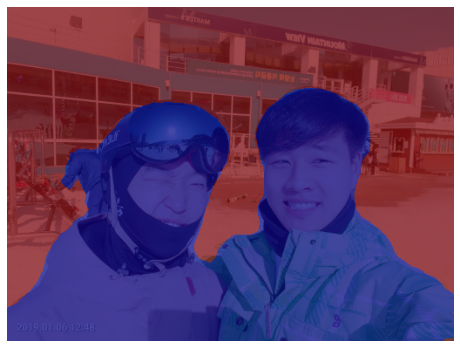

In [8]:
person_mask = person_mask.astype(np.uint8)                    # applyColorMap 메소드를 사용하기 위해 data type을 unt8로 변환
color_mask = cv2.applyColorMap(person_mask, cv2.COLORMAP_JET) # array에 있는 idx별 색상 정의
show = cv2.addWeighted(image_show, 0.3, color_mask, 0.7, 0)   # 원본 이미지에 정의한 색상 적용

plt.figure(figsize=(8, 8))
plt.imshow(show); plt.axis('off'); plt.show()

### 배경 Blur 처리
**Average Smoothing Filter를 이용해 Blur 처리**
- ```sigma```값에 따라 Blur의 정도 조절
- 가장 이상적인 sigma값을 위해 여러 수치로 적용 후 선택
> **Sigma를 높게 할수록 인물이 더욱 focusing이 된다.**

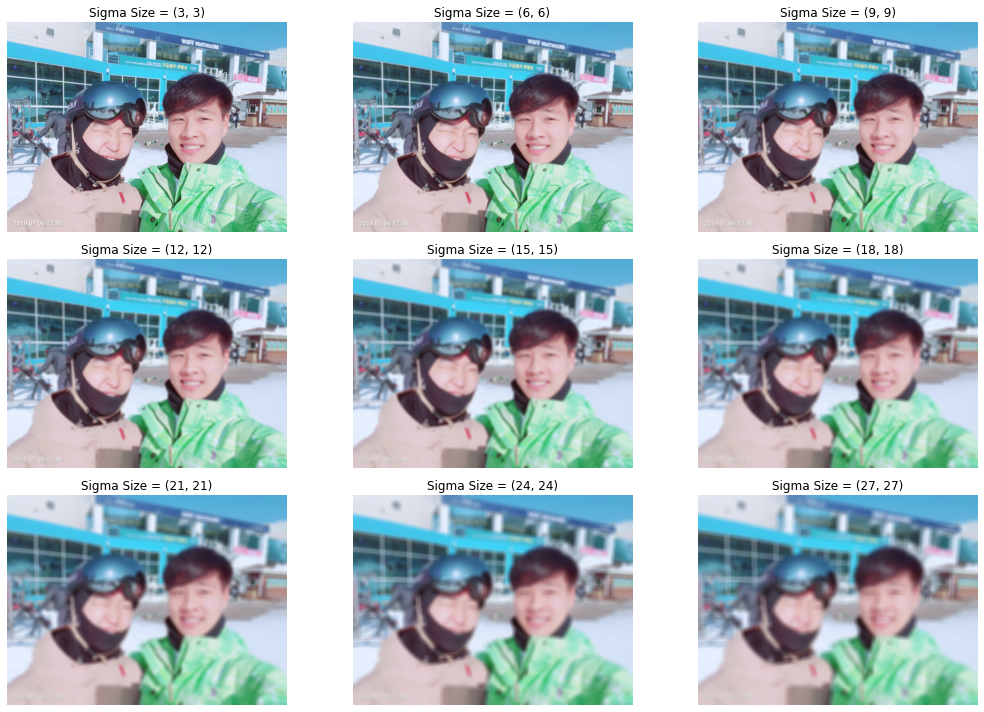

In [9]:
plt.figure(figsize=(15,10))
for i in range(1, 10):
    plt.subplot(3,3,i)
    bg_blur = cv2.blur(image, (i*3,i*3))       # Blur Filter 적용
    plt.imshow(bg_blur)
    plt.axis("off")
    plt.title(f'Sigma Size = ({i*3}, {i*3})')
    
plt.tight_layout()

sigma = (29, 29)                                # sigma값을 (29,29)로 결정
bg_blur = cv2.blur(image, sigma)

### 원본 사진으로 Resize
원본 이미지에서 Mask를 적용하기 위해 원본 사이즈로 변경
- DeepLab 모델을 적용하면 최대 513x513로 자동변경되기에 원본 이미지에 맞게 resize 필요

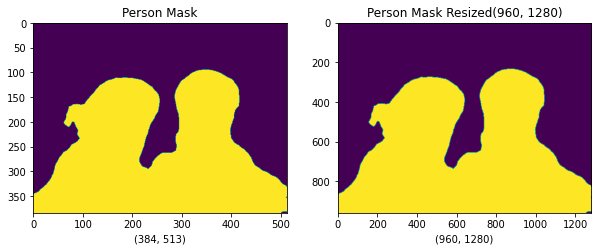

In [10]:
original_size = image.shape[:2]
person_mask_up = cv2.resize(person_mask, original_size[::-1], interpolation=cv2.INTER_LINEAR) # 원본 이미지로 Resize

plt.figure(figsize=(10,10))
plt.subplot(1,2,1); plt.imshow(person_mask); plt.title(f'Person Mask')
plt.xlabel(person_mask.shape)
plt.subplot(1,2,2); plt.imshow(person_mask_up); plt.title(f'Person Mask Resized{person_mask_up.shape}')
plt.xlabel(person_mask_up.shape)
plt.show()

### Focus Image 생성
**Mask부분이 255일 때 원본 이미지, 아니면 Blur된 배경이미지 적용**
- ```np.where```메소드를 사용하기 위해 Mask도 원본 이미지와 같은 Channel로 변경

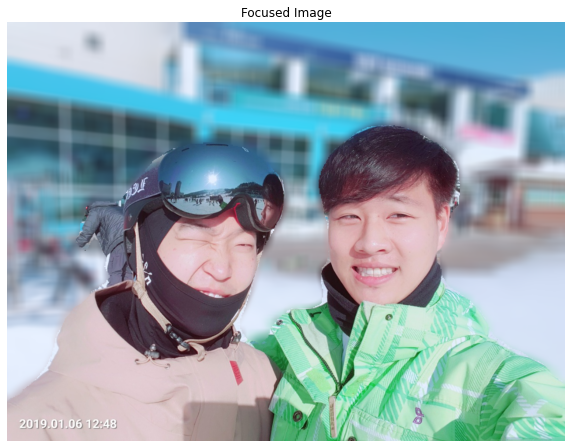

In [11]:
person_mask_color = cv2.cvtColor(person_mask_up, cv2.COLOR_GRAY2RGB)  # 원본 이미지와 같은 Channel로 변환(Gray to RGB)
focus_image = np.where(person_mask_color == 255, image, bg_blur)      # 특정 조건에 만족할 때 각각 원본 이미지와 배경이미지 적용

plt.figure(figsize=(10,10))
plt.imshow(focus_image); plt.axis('off'); plt.title('Focused Image');
plt.show()

# Focusing 메소드 만들기
**Focsing을 쉽고 빠르게 적용하기 위해 메소드로 만들어서 사용**
- 반환값은 나중에 사용될 수 있는 ```Person Class```와 ```blur background```, ```focused image```

In [12]:
def focus_image(image, label, sigma=(9,9), verbose=1):
    if verbose:
        print('Input Image Shape : ', image.shape, '\n')
    LABEL_NAMES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
                'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
                'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv']
    
    class_to_idx = {class_ : idx for idx, class_ in enumerate(LABEL_NAMES)}
    
    if verbose:
        print(f'Try to get {label} class....\n')
    resized_image, seg_map = model.run(image)
    detected_classes = np.unique(seg_map)
    
    class_exist = class_to_idx[label] in detected_classes
    if not class_exist:
        print(f"There is no {label} in the Image")
    
    if verbose:
        print("*"*30 + f'{len(detected_classes)} class detected!' + '*'*30 + '\n')

        for cls in detected_classes:
            if cls == class_to_idx[label]:
                print(f'{LABEL_NAMES[cls]}({cls}) <<<< got it!')
            else:
                print(f'{LABEL_NAMES[cls]}({cls})')
    
    
    class_mask = np.where(seg_map == class_to_idx[label], 255, 0).astype(np.uint8)
    
    bg_blur = cv2.blur(image, sigma)
    
    original_size = image.shape[:2]
    class_mask_up = cv2.resize(class_mask, original_size[::-1], interpolation=cv2.INTER_LINEAR)
    class_mask_color = cv2.cvtColor(class_mask_up, cv2.COLOR_GRAY2RGB)
    
    focus_image = np.where(class_mask_color == 255, image, bg_blur)
    if verbose:
        print('\nFocusing Image Finished...')
    
    return class_mask_up, bg_blur, focus_image

### Focusing Method를 이용해 바로 적용

Input Image Shape :  (960, 1280, 3) 

Try to get person class....

******************************2 class detected!******************************

background(0)
person(15) <<<< got it!

Focusing Image Finished...


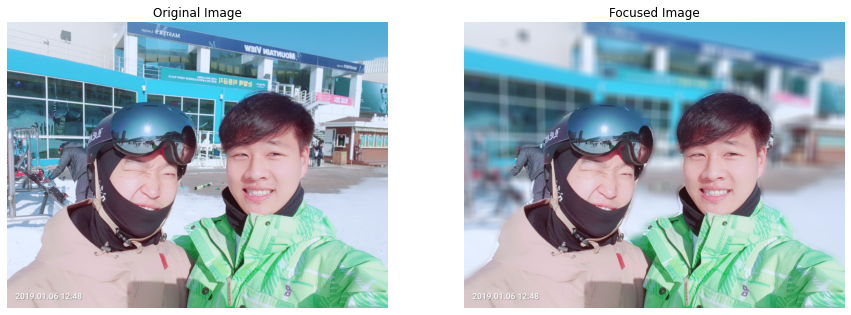

In [13]:
image_dir = os.getenv("HOME") + '/aiffel/human_segmentation/images/'
file_name = 'sakong2.jpg'

image = Image.open(os.path.join(image_dir, file_name))
image = np.array(image)

class_mask, _, focused_image = focus_image(image, 'person', sigma=(29,29))  # Focusing Method 적용

plt.figure(figsize=(15,15))
plt.subplot(1,2,1); plt.imshow(image); plt.axis('off')
plt.title('Original Image')
plt.subplot(1,2,2); plt.imshow(focused_image); plt.axis('off');
plt.title('Focused Image')
plt.show()

### 멍멍이 적용

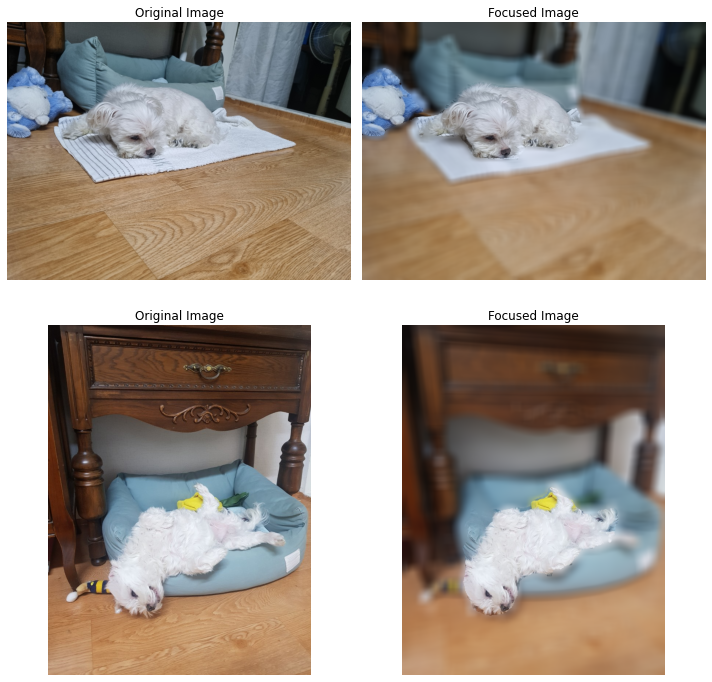

In [14]:
image_dir = os.getenv("HOME") + '/aiffel/human_segmentation/images/'
file_name1 = 'dog1.jpg'
file_name2 = 'dog2.jpg'

img1 = Image.open(os.path.join(image_dir, file_name1))
img1 = np.array(img1)
img2 = Image.open(os.path.join(image_dir, file_name2))
img2 = np.array(img2)

_, _, show1 = focus_image(img1, 'dog', sigma=(29,29), verbose=0)
_, _, show2 = focus_image(img2, 'dog', sigma=(29,29), verbose=0)

plt.figure(figsize=(10,10))
plt.subplot(2,2,1); plt.imshow(img1); plt.axis('off')
plt.title('Original Image')
plt.subplot(2,2,2); plt.imshow(show1); plt.axis('off');
plt.title('Focused Image')
plt.subplot(2,2,3); plt.imshow(img2); plt.axis('off')
plt.title('Original Image')
plt.subplot(2,2,4); plt.imshow(show2); plt.axis('off');
plt.title('Focused Image')

plt.tight_layout()
plt.show()

# 문제 식별 및 해결
1. 불필요한 인원까지 포커싱되는 문제
2. 배경과 인물의 경계 부자연스러움

## 문제1. 불필요한 인원 포함
**Segmentation을 적용했을 때 우리가 원하는 인물들이 아닌 다른 사람들까지 같이 Segmentation이 되는 문제가 있음**
- DeepLab에서는 Semantic Segmentation만 가능하기 때문에 Instance Segmentation이 가능한 모델 사용
- Instance Segmentation이 가능한 모델 중 가장 유명한 **Mask-RCNN** 모델을 이용
> **Instance Segmentation적용 시 같은 Class안에서 각각 다른 Instance로 취급하기 때문에 분리 가능**

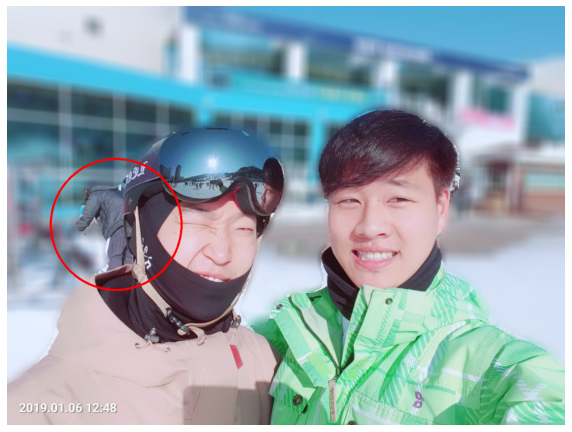

In [15]:
plt.figure(figsize=(10,10))
show = focused_image.copy()
plt.imshow(cv2.circle(show, (250, 500), 150, (255, 0, 0), 3))
plt.axis('off')
plt.show()

### Mask-RCNN 적용
**같은 Person Class 중 각각 다른 Person으로 분리**

Using TensorFlow backend.


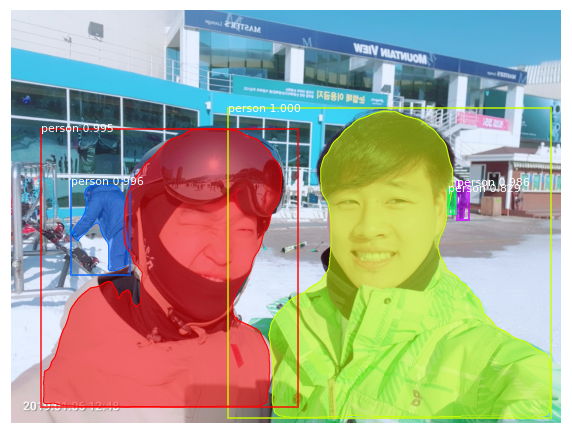

In [16]:
import mrcnn
import mrcnn.config
import mrcnn.model
import mrcnn.visualize
import cv2
import os

CLASS_NAMES = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 
               'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 
               'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 
               'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 
               'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 
               'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 
               'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 
               'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

# Mask-RCNN 적용 시 설정할 옵션
class SimpleConfig(mrcnn.config.Config):
    NAME = "coco_inference"
    GPU_COUNT = 1                  # GPU 1개 사용
    IMAGES_PER_GPU = 1             # Image 1개당 사용할 GPU
    NUM_CLASSES = len(CLASS_NAMES) # class의 종류
    
# Mask-RCNN 모델 정의
model_mrcnn = mrcnn.model.MaskRCNN(mode="inference",   # 학습이 아닌 실제 적용이기 때문에 Inference
                             config=SimpleConfig(),    # 위에 정의한 옵션 적용
                             model_dir=os.getcwd())    # 모델이 저장되어있는 디렉토리

# 사전학습된 가중치 불러오기
model_mrcnn.load_weights(filepath="mask_rcnn_coco.h5", by_name=True)

# 이미지 불러오기
image = cv2.imread(os.path.join(image_dir, file_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 모델 적용
r = model_mrcnn.detect([image], verbose=0)
r = r[0]

# 결과 시각화
mrcnn.visualize.display_instances(image=image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'], 
                                  class_names=CLASS_NAMES, 
                                  scores=r['scores'],
                                  figsize=(10,10))

## 사용하지 않는 Person 삭제
**Mask-RCNN 모델 결과 중 사용하지 않는 Person 삭제**
- 많은 Person이 탐지되었지만, DeepLab과 겹치는 Person만 삭제

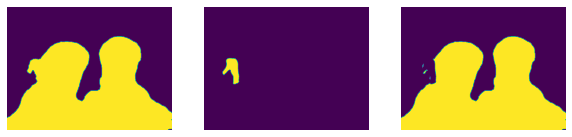

In [17]:
remove_idx = 1                       # DeepLab 모델과 겹치는 Person index
remove_person = r['masks'][:,:,1]    # Mask-RCNN 모델 결과 중 idx==1인 Person 추출

clean_mask = np.where(remove_person == 1, 0, class_mask)  # Person Mask 중 idx==1인 Person은 삭제

plt.figure(figsize=(10,10))
plt.subplot(1,3,1); plt.imshow(class_mask); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(remove_person); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(clean_mask); plt.axis('off')
plt.show()

### 불필요한 인물 삭제 결과

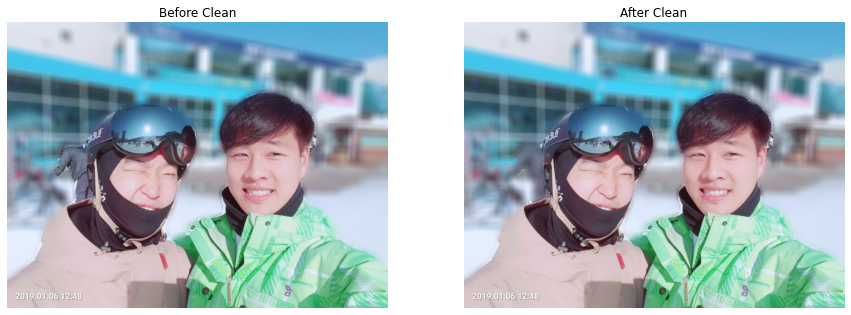

In [18]:
# 원본 이미지와 같은 Channel로 변경
clean_mask_color = cv2.cvtColor(clean_mask, cv2.COLOR_GRAY2RGB)
focus_image_clean = np.where(clean_mask_color == 255, image, bg_blur)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(focused_image); plt.axis('off'); plt.title('Before Clean');
plt.subplot(1,2,2)
plt.imshow(focus_image_clean); plt.axis('off'); plt.title('After Clean');
plt.show()

## 문제2. 배경과 인물 경계선의 부자연스러움
**인물 Mask를 만들었을 때 배경과 인물의 경계 부분을 자연스럽게 이어주기 위해 blur 처리**
- Blur처리 된 Mask의 결과를 Weight로 사용하여 원본 이미지와 곱하여 연해진 Image 추출
- Blur처리 된 Background 결과를 Weight로 사용하여 원본 이미지와 곱하여 연해진 Background 추출

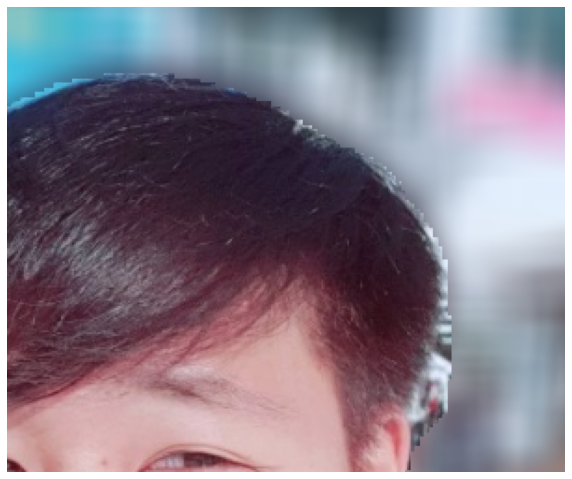

In [19]:
plt.figure(figsize=(10,10))
plt.imshow(focus_image_clean[200:450, 800:1100])
plt.axis("off"); plt.show()

### Mask Weight 구하기

Text(0.5, 1.0, 'Person Mask Weight')

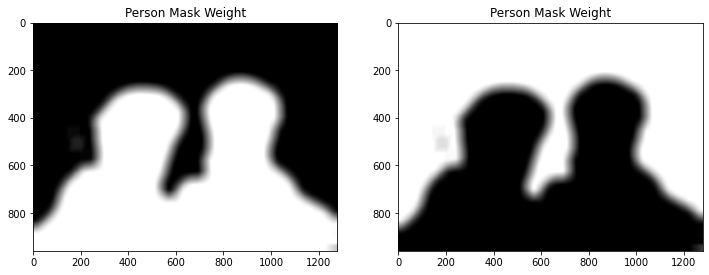

In [20]:
person_mask_weight = (cv2.blur(clean_mask, (55, 55)) / 255).astype(np.float32)  # 인물 Mask에 Blur처리
bg_blur_weight = (1 - person_mask_weight).astype(np.float32)                    # Blur처리 된 Background 추출

plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.imshow(person_mask_weight, cmap='gray')
plt.title('Person Mask Weight')
plt.subplot(1,2,2); plt.imshow(bg_blur_weight, cmap='gray')
plt.title('Person Mask Weight')

### Mask Weight 적용

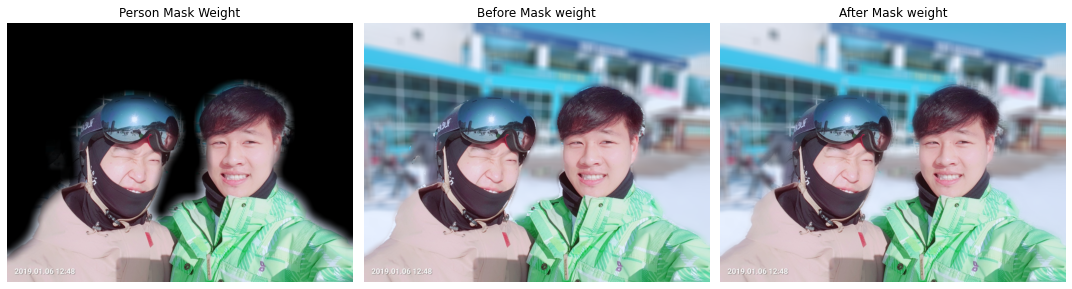

In [21]:
# element-wise 곱을 하기 위해 같은 Channel로 변환
person_mask_weight_color = cv2.cvtColor(person_mask_weight, cv2.COLOR_GRAY2RGB)
bg_blur_weight_color = cv2.cvtColor(bg_blur_weight, cv2.COLOR_GRAY2RGB)

# 각각 인물 Mask와 Background에 weight 적용
person_mask_color = (image * person_mask_weight_color).astype(np.int32)
bg_blur = (bg_blur * bg_blur_weight_color).astype(np.int32)

# weight가 적용된 인물 Mask와 Background 병합
result = person_mask_color + bg_blur

plt.figure(figsize=(15,15))
plt.subplot(1,3,1); plt.imshow(person_mask_color)
plt.title('Person Mask Weight'); plt.axis("off")

plt.subplot(1,3,2); plt.imshow(focus_image_clean)
plt.title('Before Mask weight'); plt.axis("off")

plt.subplot(1,3,3); plt.imshow(result)
plt.title('After Mask weight'); plt.axis("off")
plt.tight_layout()
plt.show()

# 이미지 합성

### 이미지 불러오기
합성하고자 하는 인물 이미지와 배경 이미지 불러오기

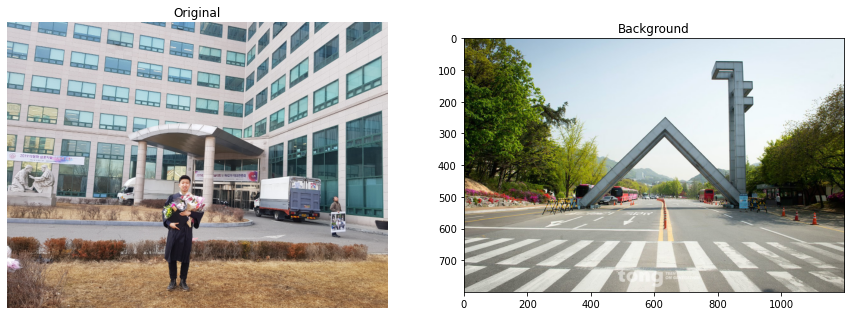

In [22]:
image_dir = os.getenv("HOME") + '/aiffel/human_segmentation/images/'
file_name1 = 'sakong.jpg'
file_name2 = 'seoul.jpg'
image1 = Image.open(os.path.join(image_dir, file_name1))
image2 = Image.open(os.path.join(image_dir, file_name2))
image1 = np.array(image1)
image2 = np.array(image2)

# 배경사진과 어울릴 수 있도록 원본 이미지 Resized
image1 = cv2.resize(image1, (640, 480), interpolation=cv2.INTER_LINEAR)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(image1); plt.axis('off'); plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(image2); plt.title('Background')
plt.show()

### Focusing 적용 후 합성
**Focusing 메소드를 적용하여 반환된 값들 중 ```Class Mask```를 이용해 합성 진행**

Input Image Shape :  (480, 640, 3) 

Try to get person class....

******************************3 class detected!******************************

background(0)
bus(6)
person(15) <<<< got it!

Focusing Image Finished...


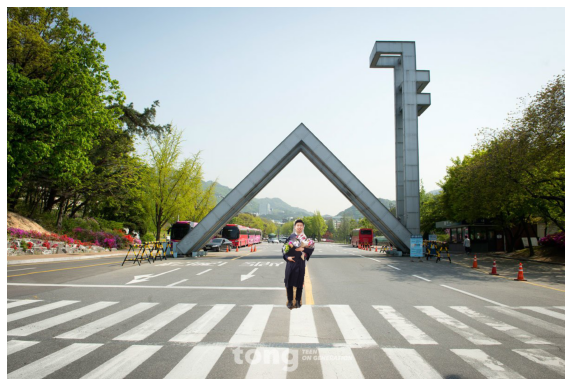

In [23]:
# Class Mask를 추출하기 위해 인물 이미지 Focusing 적용
class_mask, _, focused_image = focus_image(image1, 'person', sigma=(29,29))

# 배경 이미지에 어울리는 크기로 인물 이미지 Resize
image1_resized = image1[200:, 200:400]
class_mask_resized = class_mask[200:, 200:400]
focused_image_resized = focused_image[200:, 200:400]

class_mask_resized_color = cv2.cvtColor(class_mask_resized, cv2.COLOR_GRAY2RGB)

# 배경 이미지에 인물 이미지 적용
image2[400:400+280, 530:530+200] = np.where(class_mask_resized_color == 255, 
                                            focused_image_resized, 
                                            image2[400:400+280, 530:530+200])

plt.figure(figsize=(10,10))
plt.imshow(image2); plt.axis("off"); plt.show()

# 결과 및 고찰
- Segmentation 적용 결과 문제점은 크게 2가지로 나타났다.
  1. 이미지 내에서 Focusing을 적용해야하는 인물 이외에 상관없는 인물들이 탐지된다.
    - 문제가 발생한 이유는 탐지된 인물들이 서로 다른 인물로 분리되지 않았기 때문이다.(Semantic Segmentation의 한계)
    - 따라서 각각 Class가 분리될 수 있도록 Instance Segmentation 모델인 **Mask-RCNN** 활용
  2. 배경을 Blur처리한 후에 인물을 추가하면 두 경계가 부자연스럽게 나타난다.
    - 문제가 발생한 이유는 Blur처리된 배경에 원본 이미지의 인물이 추가되면 두 이미지의 Texture차이로 경계가 생긴다.
    - 따라서 해당 경계를 Blur처리하여 자연스럽게 합쳐질 수 있도록 조치
  3. 이 밖에도 특정 인물이 탐지되지 않는 문제가 있지만, 이 문제는 모델의 성능에 따라 좌우되기 때문에 더 많은 데이터를 이용해 학습해야한다.
  
<br>

- Segmentation Task를 처음 수행해보았기 때문에 좋은 경험이 되었다.
- Segmentation 모델을 봤을 때 픽셀 하나하나를 탐지해야하기 때문에 다른 모델보다 더 복잡한 것 같다.
- 카메라 내에서 Focusing 기능이 실시간으로 적용되기 위해서는 더욱 빠른 언어를 이용해 개발해야할 것 같다.

> **꼭 인물사진이 아니더라도 보안이 필요한 이미지의 경우에도 활용될 수 있을 것 같다.(ex. 군대)**